In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

# Data Cleaning

Let's look at the data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From top down, several initial transformations must take place.

Date: change to date time

Waterfront: inspect NaNs (and likely drop)
Other columns that require further inspection:
    -View, Condition, Grade, Year Renovated

Sqft Basement: convert to float

In [4]:
# Date to datetime
df['date'] = pd.to_datetime(df['date'])

# Add year column
df['year'] = pd.DatetimeIndex(df['date']).year

# SQFT Basement to float
df.drop(df.loc[df['sqft_basement'] == '?'].index, inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

Now let's look at values for the other colummns to see if there's anything obvious for us to drop

First just the columns with categorical or narrowly discrete units

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year'],
      dtype='object')

In [6]:
df['bedrooms'].unique()

# Drop entry with 33 Bedrooms
df.drop(df.loc[df['bedrooms'] == 33].index, inplace=True)

df['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10])

In [7]:
df['bathrooms'].unique()

# Drop entry with 0.5 bathrooms
df.drop(df.loc[df['bathrooms'] == 0.5].index, inplace=True)

df['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 5.5 , 6.75,
       5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [8]:
df['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [9]:
df['waterfront'].unique()
df['waterfront'].value_counts(dropna=False)

NO     18658
NaN     2339
YES      142
Name: waterfront, dtype: int64

Although there are over 2,000 counts of NaN for waterfront, I feel fairly comfortable turning these NaNs to "No"s

In [10]:
# Turn NaNs to No
df['waterfront'] = df['waterfront'].fillna('NO')

# Convert to 0 or 1
mapdict = {'YES': 1, 'NO': 0}
df['waterfront'] = df['waterfront'].map(mapdict)

# Check result
df['waterfront'].value_counts(dropna=False)

0    20997
1      142
Name: waterfront, dtype: int64

In [11]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year'],
      dtype='object')

In [12]:
df['view'].value_counts()

NONE         19014
AVERAGE        930
GOOD           496
FAIR           327
EXCELLENT      311
Name: view, dtype: int64

In [13]:
# Create Yes/No column for view
df['view_y_n'] = df['view'].apply(lambda x: 0 if x == 'NONE' else 1)
df['view_y_n'].value_counts()

# Actually let's just drop view because so many are None.
df.drop(['view_y_n', 'view'], axis = 1, inplace=True)

# Let's also drop the latitude and longitude values
df.drop(['lat', 'long'], axis = 1, inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21139 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21139 non-null  int64         
 1   date           21139 non-null  datetime64[ns]
 2   price          21139 non-null  float64       
 3   bedrooms       21139 non-null  int64         
 4   bathrooms      21139 non-null  float64       
 5   sqft_living    21139 non-null  int64         
 6   sqft_lot       21139 non-null  int64         
 7   floors         21139 non-null  float64       
 8   waterfront     21139 non-null  int64         
 9   condition      21139 non-null  object        
 10  grade          21139 non-null  object        
 11  sqft_above     21139 non-null  int64         
 12  sqft_basement  21139 non-null  float64       
 13  yr_built       21139 non-null  int64         
 14  yr_renovated   17385 non-null  float64       
 15  zipcode        2113

In [14]:
df['condition'].value_counts()

# Map numerical values

mapdict = {'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}
df['condition'] = df['condition'].map(mapdict)


df['condition'].value_counts()

2    13724
3     5556
4     1665
1      166
0       28
Name: condition, dtype: int64

In [15]:
df['grade'].value_counts()

7 Average        8787
8 Good           5933
9 Better         2557
6 Low Average    1995
10 Very Good     1112
11 Excellent      391
5 Fair            234
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [16]:
df['grade'] = df.grade.str.split(' ').str[0]
df['grade'] = df['grade'].astype(int)

In [17]:
df.head(3)

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   

   sqft_lot  floors  waterfront  condition  grade  sqft_above  sqft_basement  \
0      5650     1.0           0          2      7        1180            0.0   
1      7242     2.0           0          2      7        2170          400.0   
2     10000     1.0           0          2      6         770            0.0   

   yr_built  yr_renovated  zipcode  sqft_living15  sqft_lot15  year  
0      1955           0.0    98178           1340        5650  2014  
1      1951        1991.0    98125           1690        7639  2014  
2      1933           NaN    98028           2720        8062  2015

# Get Metric for general property value by zipcode

In [18]:
HPI_df = pd.read_csv('data/HPI_AT_BDL_ZIP5.csv')

HPI_df.columns = HPI_df.columns.str.replace(' ', '_')

HPI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605415 entries, 0 to 605414
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Five-Digit_ZIP_Code  605415 non-null  int64  
 1   Year                 605415 non-null  int64  
 2   Annual_Change_(%)    605415 non-null  object 
 3   HPI                  605415 non-null  object 
 4   HPI_with_1990_base   605415 non-null  object 
 5   HPI_with_2000_base   605415 non-null  object 
 6   Unnamed:_6           0 non-null       float64
 7   Unnamed:_7           0 non-null       float64
dtypes: float64(2), int64(2), object(4)
memory usage: 37.0+ MB


In [19]:
# Drop unnecessary columns

HPI_df.drop(['Annual_Change_(%)', 'Unnamed:_6', 'Unnamed:_7'], axis = 1, inplace=True)

In [20]:
# Change columns to numeric

HPI_df['HPI'] = pd.to_numeric(HPI_df['HPI'], errors = 'coerce')
HPI_df['HPI_with_1990_base'] = pd.to_numeric(HPI_df['HPI_with_1990_base'], errors = 'coerce')
HPI_df['HPI_with_2000_base'] = pd.to_numeric(HPI_df['HPI_with_2000_base'], errors = 'coerce')

# Rename colummns

HPI_df.rename(columns = {'Five-Digit_ZIP_Code': 'zipcode', 'Year': 'year'}, inplace=True)

In [21]:
# Merge dataframes

df_merged = pd.merge(df, HPI_df, on = ['zipcode', 'year'], how='left')

In [22]:
df_merged.head(5)

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  condition  ...  sqft_basement  yr_built  \
0      5650     1.0           0          2  ...            0.0      1955   
1      7242     2.0           0          2  ...          400.0      1951   
2     10000     1.0           0          2  ...            0.0      1933   
3      5000     1.0           0          4  ...          910.0      1965   
4      8080     1.0           0          2  ...            0.0      1987   

   yr_renovated  zipcode  sqft_living15  sqft_lot15  year      HPI  \
0           0.0    98178           1340        5650  2014   661.52   
1        1991.0    98125           1690        7639  2014  1141.29   
2           NaN    98028           2720        8062  2015   786.52   
3           0.0    98136           1360        5000  2014  1232.44   
4           0.0    98074           1800        7503  2015   777.58   

   HPI_with_1990_base  HPI_with_2000_base  
0              232.95              136.93  
1              273.02              170.20  
2              280.44              173.73  
3              290.53              171.98  
4              263.49              180.53  

[5 rows x 22 columns]

In [23]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21139 entries, 0 to 21138
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  21139 non-null  int64         
 1   date                21139 non-null  datetime64[ns]
 2   price               21139 non-null  float64       
 3   bedrooms            21139 non-null  int64         
 4   bathrooms           21139 non-null  float64       
 5   sqft_living         21139 non-null  int64         
 6   sqft_lot            21139 non-null  int64         
 7   floors              21139 non-null  float64       
 8   waterfront          21139 non-null  int64         
 9   condition           21139 non-null  int64         
 10  grade               21139 non-null  int64         
 11  sqft_above          21139 non-null  int64         
 12  sqft_basement       21139 non-null  float64       
 13  yr_built            21139 non-null  int64     

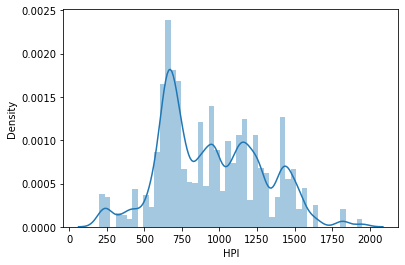

In [24]:
sns.distplot(df_merged['HPI']);

# Alternative Method

In [25]:
df_merged['zip_mean'] = df_merged.groupby('zipcode')['price'].transform('mean')
df_merged['zip_count'] = df_merged.groupby('zipcode')['zipcode'].transform('count')

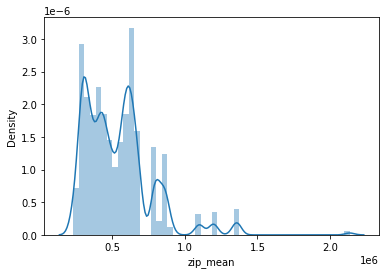

In [26]:
sns.distplot(df_merged['zip_mean']);

# Regression

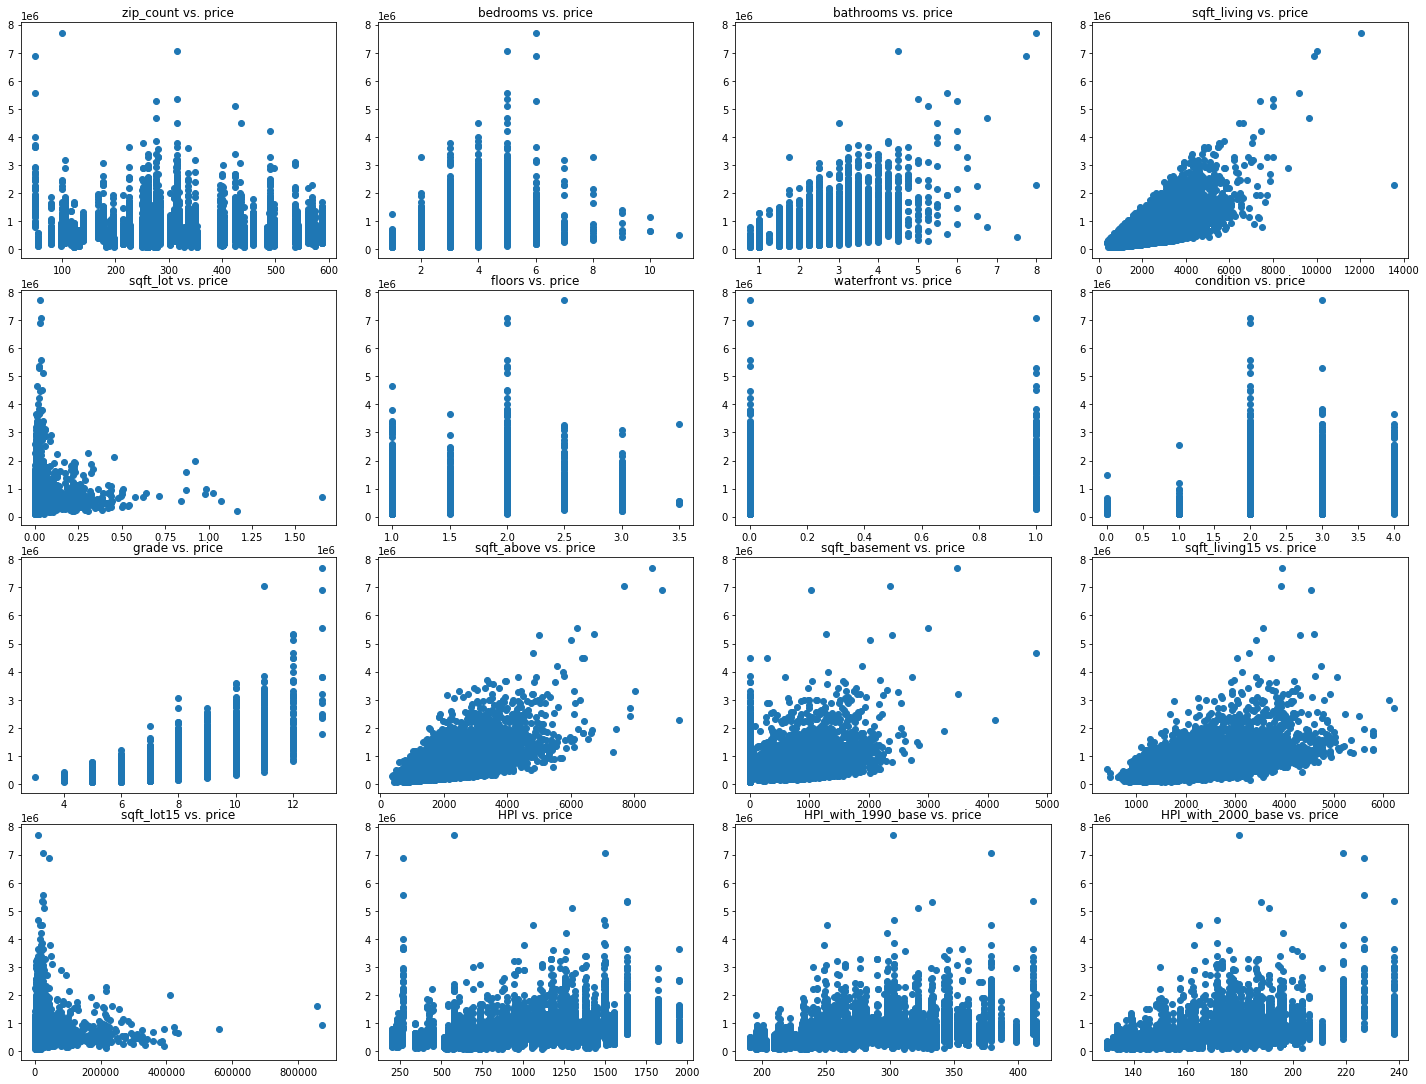

In [27]:
fig, axs = plt.subplots(4,4)

fig.set_figheight(15)
fig.set_figwidth(20)
plt.tight_layout()
X = df_merged.drop(columns=['price', 'date', 'id', 'yr_built', 'yr_renovated', 'zipcode', 'year'])
Y = df_merged['price']
column_num = 0

for i in range(4):
    for j in range(4):
        axs[i,j].scatter(X.iloc[:,(column_num-1)], Y)
        axs[i,j].set_title('{} vs. {}'.format(X.columns[column_num-1], 'price'))
        column_num += 1

In [28]:
df_merged.corr()

id     price  bedrooms  bathrooms  sqft_living  \
id                  1.000000 -0.015703  0.003924   0.006290    -0.011609   
price              -0.015703  1.000000  0.316445   0.525829     0.702298   
bedrooms            0.003924  0.316445  1.000000   0.527271     0.593226   
bathrooms           0.006290  0.525829  0.527271   1.000000     0.755217   
sqft_living        -0.011609  0.702298  0.593226   0.755217     1.000000   
sqft_lot           -0.132260  0.087916  0.033359   0.087838     0.172916   
floors              0.019331  0.256286  0.184795   0.503978     0.354571   
waterfront         -0.002916  0.265976  0.000168   0.064620     0.106036   
condition          -0.023033  0.035240  0.022512  -0.128059    -0.061301   
grade               0.008823  0.667709  0.366484   0.666336     0.763031   
sqft_above         -0.010468  0.605110  0.492504   0.686332     0.876651   
sqft_basement      -0.004502  0.325023  0.309415   0.282828     0.434655   
yr_built            0.022345  0.054318  0.161919   0.508237     0.319286   
yr_renovated       -0.010588  0.128209  0.019971   0.051674     0.054246   
zipcode            -0.011236 -0.053056 -0.156988  -0.204070    -0.198758   
sqft_living15      -0.003010  0.586407  0.403775   0.570094     0.756375   
sqft_lot15         -0.137996  0.083168  0.031640   0.088779     0.184434   
year                0.009007  0.004642 -0.008213  -0.025477    -0.027297   
HPI                 0.000764  0.359010 -0.002791  -0.018094     0.004050   
HPI_with_1990_base  0.013948  0.422239 -0.049517   0.001393     0.001043   
HPI_with_2000_base  0.000060  0.472474  0.015885   0.060797     0.083154   
zip_mean           -0.004028  0.637972  0.128617   0.226786     0.298430   
zip_count           0.041012 -0.049847 -0.002432  -0.001286    -0.029046   

                    sqft_lot    floors  waterfront  condition     grade  ...  \
id                 -0.132260  0.019331   -0.002916  -0.023033  0.008823  ...   
price               0.087916  0.256286    0.265976   0.035240  0.667709  ...   
bedrooms            0.033359  0.184795    0.000168   0.022512  0.366484  ...   
bathrooms           0.087838  0.503978    0.064620  -0.128059  0.666336  ...   
sqft_living         0.172916  0.354571    0.106036  -0.061301  0.763031  ...   
sqft_lot            1.000000 -0.007562    0.021208  -0.009655  0.113367  ...   
floors             -0.007562  1.000000    0.020295  -0.264258  0.459108  ...   
waterfront          0.021208  0.020295    1.000000   0.016739  0.083599  ...   
condition          -0.009655 -0.264258    0.016739   1.000000 -0.148552  ...   
grade               0.113367  0.459108    0.083599  -0.148552  1.000000  ...   
sqft_above          0.183435  0.524127    0.072193  -0.159269  0.756304  ...   
sqft_basement       0.015543 -0.245134    0.084955   0.170890  0.168071  ...   
yr_built            0.052719  0.489575   -0.023866  -0.362191  0.447962  ...   
yr_renovated        0.003480  0.003212    0.077635  -0.062250  0.016844  ...   
zipcode            -0.129329 -0.058832    0.028169   0.003371 -0.184939  ...   
sqft_living15       0.143402  0.280192    0.085167  -0.093410  0.713574  ...   
sqft_lot15          0.720646 -0.011593    0.030246  -0.004840  0.121878  ...   
year                0.004986 -0.021721   -0.006100  -0.044654 -0.028924  ...   
HPI                -0.164550  0.009794   -0.004186   0.111507  0.085402  ...   
HPI_with_1990_base -0.132665  0.097417   -0.008532   0.044362  0.085042  ...   
HPI_with_2000_base -0.120788  0.065582   -0.000036   0.046400  0.177031  ...   
zip_mean           -0.032091  0.128009    0.020212   0.051863  0.371476  ...   
zip_count          -0.104027  0.036739   -0.035775   0.004593 -0.008161  ...   

                    yr_renovated   zipcode  sqft_living15  sqft_lot15  \
id                     -0.010588 -0.011236      -0.003010   -0.137996   
price                   0.128209 -0.053056       0.586407    0.083168   
bedrooms                0.019971 -0.156988       0.403775    

<AxesSubplot:>

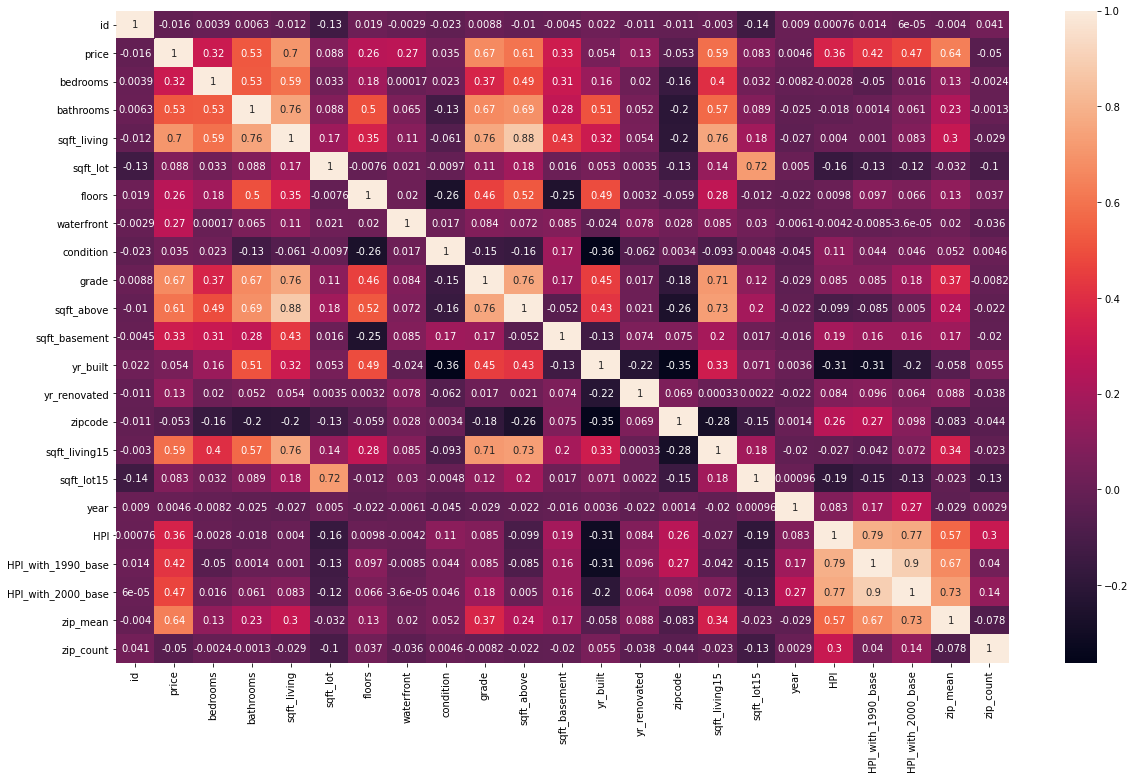

In [29]:
plt.figure(figsize=(20,12))
sns.heatmap(df_merged.corr(),annot=True)

In [30]:
columnstodrop = ['price','date','id','sqft_lot15','zip_count','sqft_basement','year',
                 'HPI_with_1990_base', 'HPI_with_2000_base', 'sqft_living15']

df_merged = df_merged.dropna(subset=['yr_renovated'])
df_merged = df_merged.dropna(subset=['HPI'])

In [31]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17376 entries, 0 to 21138
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  17376 non-null  int64         
 1   date                17376 non-null  datetime64[ns]
 2   price               17376 non-null  float64       
 3   bedrooms            17376 non-null  int64         
 4   bathrooms           17376 non-null  float64       
 5   sqft_living         17376 non-null  int64         
 6   sqft_lot            17376 non-null  int64         
 7   floors              17376 non-null  float64       
 8   waterfront          17376 non-null  int64         
 9   condition           17376 non-null  int64         
 10  grade               17376 non-null  int64         
 11  sqft_above          17376 non-null  int64         
 12  sqft_basement       17376 non-null  float64       
 13  yr_built            17376 non-null  int64     

In [32]:
y = df_merged['price']
x = sm.add_constant(df_merged.drop(columns=columnstodrop))
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17376 entries, 0 to 21138
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         17376 non-null  float64
 1   bedrooms      17376 non-null  int64  
 2   bathrooms     17376 non-null  float64
 3   sqft_living   17376 non-null  int64  
 4   sqft_lot      17376 non-null  int64  
 5   floors        17376 non-null  float64
 6   waterfront    17376 non-null  int64  
 7   condition     17376 non-null  int64  
 8   grade         17376 non-null  int64  
 9   sqft_above    17376 non-null  int64  
 10  yr_built      17376 non-null  int64  
 11  yr_renovated  17376 non-null  float64
 12  zipcode       17376 non-null  int64  
 13  HPI           17376 non-null  float64
 14  zip_mean      17376 non-null  float64
dtypes: float64(6), int64(9)
memory usage: 2.1 MB


In [33]:
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     4312.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:21:12   Log-Likelihood:            -2.3437e+05
No. Observations:               17376   AIC:                         4.688e+05
Df Residuals:                   17361   BIC:                         4.689e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.605e+07   2.86e+06     -9.125      0.000   -3.16e+07   -2.05e+07
bedrooms     -3.898e+04   1908.622    -20.422      0.000   -4.27e+04   -3.52e+04
bathrooms     3.679e+04   3155.497     11.659      0.000    3.06e+04     4.3e+04
sqft_living    161.5832      4.089     39.520      0.000     153.569     169.597
sqft_lot         0.1125      0.033      3.453      0.001       0.049       0.176
floors       -1.409e+04   3482.641     -4.046      0.000   -2.09e+04   -7263.957
waterfront    8.392e+05   1.64e+04     51.052      0.000    8.07e+05    8.71e+05
condition     1.667e+04   2264.843      7.360      0.000    1.22e+04    2.11e+04
grade         6.246e+04   2054.425     30.402      0.000    5.84e+04    6.65e+04
sqft_above      40.5137      4.103      9.875      0.000      32.472      48.555
yr_built     -1659.9153     71.089    -23.350      0.000   -1799.257   -1520.573
yr_renovated    14.8784      3.554      4.186      0.000       7.912      21.845
zipcode        291.6370     28.678     10.169      0.000     235.424     347.850
HPI            108.3542      5.505     19.682      0.000      97.563     119.145
zip_mean         0.5527      0.008     70.414      0.000       0.537       0.568
==============================================================================
Omnibus:                    17493.563   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3625593.244
Skew:                           4.498   Prob(JB):                         0.00
Kurtosis:                      73.191   Cond. No.                     1.28e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
model.rsquared

0.7766427573885102

In [35]:
x_standard = x.apply(lambda x: (x - x.mean())/x.std())
x_standard = x_standard.drop(columns = ['const'])
x_standard = sm.add_constant(x_standard)

y_standard = (y - y.mean())/y.std()

In [36]:
results_stand = sm.OLS(y_standard,x_standard).fit()
results_stand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     4312.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:21:12   Log-Likelihood:                -11632.
No. Observations:               17376   AIC:                         2.329e+04
Df Residuals:                   17361   BIC:                         2.341e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.71e-15      0.004  -4.77e-13      1.000      -0.007       0.007
bedrooms        -0.0955      0.005    -20.422      0.000      -0.105      -0.086
bathrooms        0.0765      0.007     11.659      0.000       0.064       0.089
sqft_living      0.4020      0.010     39.520      0.000       0.382       0.422
sqft_lot         0.0129      0.004      3.453      0.001       0.006       0.020
floors          -0.0205      0.005     -4.046      0.000      -0.030      -0.011
waterfront       0.1860      0.004     51.052      0.000       0.179       0.193
condition        0.0295      0.004      7.360      0.000       0.022       0.037
grade            0.1983      0.007     30.402      0.000       0.186       0.211
sqft_above       0.0908      0.009      9.875      0.000       0.073       0.109
yr_built        -0.1318      0.006    -23.350      0.000      -0.143      -0.121
yr_renovated     0.0160      0.004      4.186      0.000       0.009       0.024
zipcode          0.0423      0.004     10.169      0.000       0.034       0.050
HPI              0.0990      0.005     19.682      0.000       0.089       0.109
zip_mean         0.3481      0.005     70.414      0.000       0.338       0.358
==============================================================================
Omnibus:                    17493.563   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3625593.244
Skew:                           4.498   Prob(JB):                         0.00
Kurtosis:                      73.191   Cond. No.                         7.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [38]:
lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(x_standard, y_standard, test_size=0.2)

lr.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred = lr.predict(X_test)
MAE = round(mean_absolute_error(y_pred, y_test),2)
score = round(lr.score(X_train, y_train),2)
print('R^2 value: {}, absolute mean error: {}'.format(score,MAE))

R^2 value: 0.77, absolute mean error: 0.28
